# 1. Create image filtering methods

In [2]:
import cv2
import numpy as np
from cv2.typing import MatLike


def filter_face(frame: MatLike) -> MatLike:
    """
    Remove faces from an image and replaces with a black box

    Parameters
    ----------
    frame : numpy.ndarray
        The image to filter

    Returns
    -------
    numpy.ndarray
        The face filtered image with faces removed
    """

    # Load the face cascade classifier
    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )

    # Convert the image to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Perform face detection
    scale_factor = 1.2
    min_neighbors = 2
    faces = face_cascade.detectMultiScale(gray, scale_factor, min_neighbors)

    # Check if a face is detected
    if len(faces) > 0:
        # Get the coordinates of the face
        (x, y, w, h) = faces[0]

        # Set the region of the image that contains the face to black
        # extra black space to remove the neck and completely hide the face
        frame[
            y - 30 : y + h + 50,
            x - 10 : x + w + 10,
        ] = 0

        frame[
            y - 30 : y + h + 85,
            x + 10 : x + w - 30,
        ] = 0

    return frame


def filter_skin(frame: MatLike) -> MatLike:
    """
    Filter an image so that only the hands remain
        and the rest of the image is blacked out

    Parameters
    ----------
    frame : numpy.ndarray
        The image to filter

    Returns
    -------
    numpy.ndarray
        The filtered image
    """
    white = (255, 255, 255)
    contour_area_min_limit = 3000

    # Convert the image to the HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define a range for skin color in HSV
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)

    # Threshold the HSV image to get only skin colors
    mask = cv2.inRange(hsv, lower_skin, upper_skin)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter the contours based on their area
    hand_contours = [
        cnt for cnt in contours if cv2.contourArea(cnt) > contour_area_min_limit
    ]

    # Create a blank black image
    hand_mask = np.zeros(frame.shape[:2], dtype="uint8")

    # Draw the hand contours on the mask
    cv2.drawContours(hand_mask, hand_contours, -1, white, thickness=cv2.FILLED)

    # Set everything outside of the hand contours to black in the original image
    frame = cv2.bitwise_and(frame, frame, mask=hand_mask)

    return frame


def filter_edges(frame: MatLike) -> MatLike:
    """
    Filter an image so that only the edges remain and dilate them for clarity

    Parameters
    ----------
    frame : numpy.ndarray
        The image to filter

    Returns
    -------
    numpy.ndarray
        The filtered image
    """

    # Convert the image to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Find the edges in the image
    lower_threshold = 25
    upper_threshold = 125
    edges = cv2.Canny(gray, lower_threshold, upper_threshold)

    # Define a kernel for dilation
    kernel = np.ones((3, 3), np.uint8)

    # Dilate the edges to make them thicker
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)

    return dilated_edges


def resize_image(frame: MatLike) -> MatLike:
    """
    Resize an image to a standard size

    Parameters
    ----------
    frame : numpy.ndarray
        The image to resize

    Returns
    -------
    numpy.ndarray
        The resized image
    """

    resized_img = cv2.resize(frame, (256, 256))

    return resized_img


def apply_image_filters(frame: MatLike, resized=False) -> MatLike:
    """
    Apply all the filters to an image

    Parameters
    ----------
    frame : numpy.ndarray
        The image to filter

    resized : bool, optional
        Whether to resize the image to a standard size, by default False.
        This exists so that filters can be displayed on the original image
        size as well as the resized image size

    Returns
    -------
    numpy.ndarray
        The filtered image
    """

    face_filter = filter_face(frame)
    skin_filter = filter_skin(face_filter)
    out_img = filter_edges(skin_filter)

    if resized:
        out_img = resize_image(out_img)

    return out_img

# 2. Capture a single image

Image saved successfully


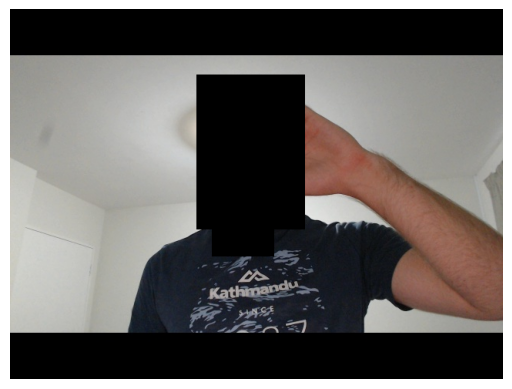

In [101]:
import cv2
import matplotlib.pyplot as plt
import time

capture = cv2.VideoCapture(1)
# Check if the camera is opened successfully
if not capture.isOpened():
    print("Unable to open the camera")

# Read a frame from the camera
ret, frame = capture.read()

# Check if the frame is read successfully
if not ret:
    print("Failed to read frame from the camera")

cv2.imwrite("./testing_data/example_visuals/overlapping.jpg", frame)
print("Image saved successfully")

# plt.imshow(filtered_face)
img = cv2.imread("./testing_data/example_visuals/overlapping.jpg")
plt.imshow(cv2.cvtColor(filter_face(img), cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# 3. Example images for verification

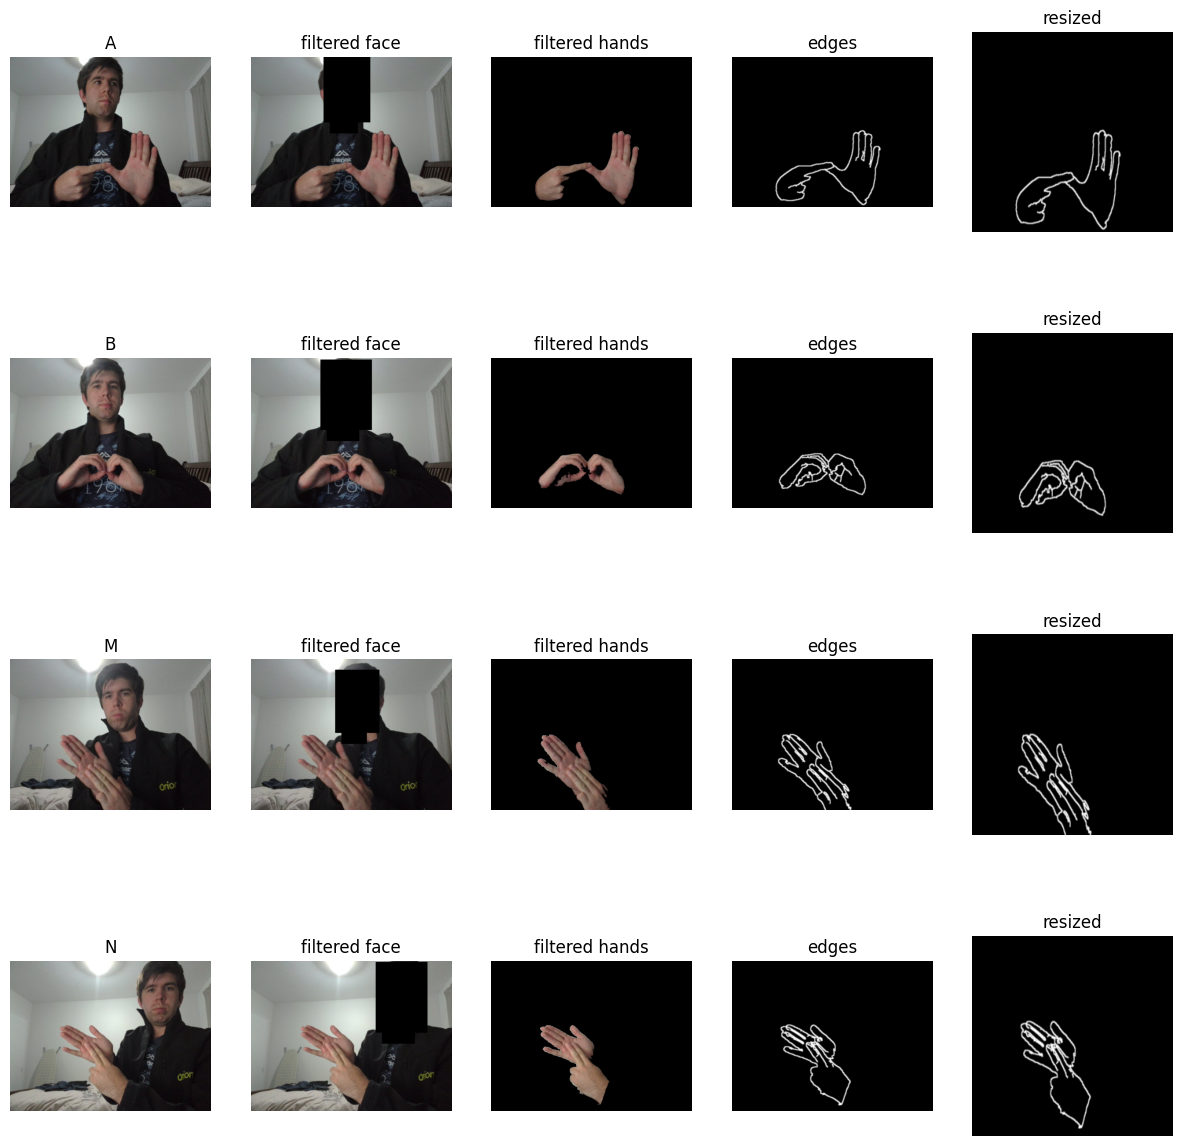

In [12]:
import matplotlib.pyplot as plt
import cv2

frame_A = cv2.imread("./testing_data/example_visuals/A.jpg")
frame_B = cv2.imread("./testing_data/example_visuals/B.jpg")
frame_C = cv2.imread("./testing_data/example_visuals/M.jpg")
frame_X = cv2.imread("./testing_data/example_visuals/N.jpg")


class ImagePlotter:
    def __init__(self, rows, cols):
        self.counter = 0
        self.rows = rows
        self.cols = cols
        self.positions = [
            i for j in range(cols) for i in range(j + 1, rows * cols + 1, cols)
        ]

    def plot_image(self, name, frame):
        plt.subplot(self.rows, self.cols, self.positions[self.counter])
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(name)
        self.counter += 1


plotter = ImagePlotter(4, 5)

plt.figure(figsize=(15, 15))

plotter.plot_image("A", frame_A)
plotter.plot_image("B", frame_B)
plotter.plot_image("M", frame_C)
plotter.plot_image("N", frame_X)

frame_A = filter_face(frame_A)
frame_B = filter_face(frame_B)
frame_C = filter_face(frame_C)
frame_X = filter_face(frame_X)

plotter.plot_image("filtered face", frame_A)
plotter.plot_image("filtered face", frame_B)
plotter.plot_image("filtered face", frame_C)
plotter.plot_image("filtered face", frame_X)

frame_A = filter_skin(frame_A)
frame_B = filter_skin(frame_B)
frame_C = filter_skin(frame_C)
frame_X = filter_skin(frame_X)

plotter.plot_image("filtered hands", frame_A)
plotter.plot_image("filtered hands", frame_B)
plotter.plot_image("filtered hands", frame_C)
plotter.plot_image("filtered hands", frame_X)

frame_A = filter_edges(frame_A)
frame_B = filter_edges(frame_B)
frame_C = filter_edges(frame_C)
frame_X = filter_edges(frame_X)

plotter.plot_image("edges", frame_A)
plotter.plot_image("edges", frame_B)
plotter.plot_image("edges", frame_C)
plotter.plot_image("edges", frame_X)

frame_A = resize_image(frame_A)
frame_B = resize_image(frame_B)
frame_C = resize_image(frame_C)
frame_X = resize_image(frame_X)

plotter.plot_image("resized", frame_A)
plotter.plot_image("resized", frame_B)
plotter.plot_image("resized", frame_C)
plotter.plot_image("resized", frame_X)

plt.xlabel("")

plt.axis("off")
plt.show()

# 4. Live run of filtered image for testing

In [83]:
import cv2

# Open the video source or camera
capture = cv2.VideoCapture(0)

# Check if the video source or camera is opened successfully
if not capture.isOpened():
    print("Unable to open the video source or camera")

# Loop through the frames
while True:
    # Read a frame from the video source or camera
    ret, frame = capture.read()

    filtered_frame = apply_image_filters(frame)

    # Check if the frame is read successfully
    if not ret:
        print("Failed to read frame from the video source or camera")
        break

    # Perform operations on the frame
    # For example, you can display the frame
    cv2.imshow("Frame", filtered_frame)

    # Exit the loop if the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release the video source or camera and close all windows
capture.release()
cv2.destroyAllWindows()

# 5. Collect training data

In [4]:
# classes to collect training data for
collection_classes = [
    "hello",
    "A",
    "B",
    "C",
    "my",
    "name",
    "M",
    "N",
    "X"
]

# datapath for any relevant data for training
DATA_PATH = "./testing_data/"

# training data filepath
CSV_FILE = "./testing_data/training_data_9_classes.csv"

# frames in a sequence
capture_frames = 20

# number of sequences to capture for training
n_sequences = 50

# delay between capturing the next sequence
capture_interval = 1.5

In [27]:
import cv2
import time
import os
import pandas as pd

capture = cv2.VideoCapture(1)

# Initializing current time and previous time for calculating the FPS
previousTime = 0
currentTime = 0


previous_capture_time = time.time()
capturing = False


current_class = 0
sequences_captured = 0
capture_frame = 0

paused = -1

csv_file = open(CSV_FILE, "w")

while capture.isOpened():
    # capture frame by frame
    ret, frame = capture.read()

    # resizing the frame for better view
    image = cv2.resize(frame, (800, 600))

    # Converting the from BGR to RGB
    filtered_image = apply_image_filters(image.copy(), False)
    resized_image = resize_image(filtered_image)

    if capturing:
        # Making predictions using holistic model
        # To improve performance, image is marked as not writeable to pass by reference.

        folder_path = (
            f"{DATA_PATH}/{collection_classes[current_class]}/{sequences_captured}"
        )

        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        flattened_image = resized_image.flatten()

        if capture_frame > 0:
            # cv2.imwrite(folder_path + f"/{capture_frame}.jpg", image)

            csv_file.write(
                f"{current_class},{','.join([str(pixel) for pixel in flattened_image])}\n"
            )

        capture_frame += 1

        if capture_frame == capture_frames:
            capturing = False
            previous_capture_time = time.time()
            capture_frame = 0
            sequences_captured += 1

            if sequences_captured == n_sequences:
                sequences_captured = 0
                current_class += 1
                if current_class == len(collection_classes):
                    print("Data collection complete")
                    break

    if not capturing:
        filtered_image = cv2.cvtColor(filtered_image, cv2.COLOR_RGB2BGR)
        if paused == 1:
            cv2.putText(
                filtered_image,
                "paused, press p to continue",
                (215, 350),
                cv2.FONT_HERSHEY_COMPLEX,
                1,
                (0, 255, 0),
                2,
            )
        else:
            cv2.putText(
                filtered_image,
                "Get ready to capture",
                (225, 350),
                cv2.FONT_HERSHEY_COMPLEX,
                1,
                (0, 255, 0),
                2,
            )
            if time.time() - previous_capture_time >= capture_interval:
                capturing = True

    # Calculating the FPS
    currentTime = time.time()
    fps = 1 / (currentTime - previousTime)
    previousTime = currentTime

    # Displaying FPS on the image
    cv2.putText(
        filtered_image,
        str(int(fps)) + " FPS",
        (10, 70),
        cv2.FONT_HERSHEY_COMPLEX,
        1,
        (0, 255, 0),
        2,
    )

    cv2.putText(
        filtered_image,
        "capturing "
        + str(sequences_captured + 1)
        + " of "
        + str(n_sequences)
        + ' for "'
        + str(collection_classes[current_class])
        + '"'
        + " dclass " 
        + str(current_class + 1) 
        + " of " 
        + str(len(collection_classes)),
        (10, 575),
        cv2.FONT_HERSHEY_COMPLEX,
        1,
        (0, 255, 0),
        2,
    )

    # Display the resulting image
    cv2.imshow("Facial and Hand Landmarks", filtered_image)

    # Enter key 'q' to break the loop
    key = cv2.waitKey(5) & 0xFF

    quit_key = ord("q")
    paused_key = ord("p")

    if key == quit_key:
        break
    elif key == paused_key:
        paused *= -1
        previous_capture_time = time.time()


csv_file.close()

capture.release()
cv2.destroyAllWindows()

Data collection complete


# 8. Define the LSTM and dataset models and parameters

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset


# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training_classes = [
    "hello",
    "A",
    "B",
    "C",
    "my",
    "name",
    "M",
    "N",
    "X"
]

input_size = 256 * 256
hidden_size = 128
num_layers = 2
num_classes = len(training_classes)

accuracy_filepath = "./models/accuracy_25_epoch_9_classes.txt"


class LSTMModel(nn.Module):
    def __init__(
        self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.2
    ):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout_prob,
            bidirectional=True,
        )
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Multiply by 2 for BiLSTM

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])  # Only take the output from the last time step
        return out


class FeatureDataset(Dataset):
    def __init__(self, keypoints, labels):
        self.keypoints = keypoints
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.keypoints[idx]), torch.LongTensor(
            [self.labels[idx]]
        )

# 9. Train the LSTM model

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Load your CSV file without a header
df = pd.read_csv(CSV_FILE, header=None)

# Extract labels and keypoint data columns
labels = df.iloc[:, 0].astype("category").cat.codes.values
keypoints = df.iloc[:, 1:]

# Normalize keypoints if needed (you might want to customize this based on your data)
scaler = StandardScaler()
keypoints_normalized = scaler.fit_transform(keypoints)
capture_frames=19
# Reshape the data into sequences of x frames
keypoints_reshaped = keypoints_normalized.reshape(
    -1, capture_frames, len(keypoints.columns)
)

# Ensure the number of samples in keypoints_reshaped matches the number of labels
num_samples = min(len(labels), len(keypoints_reshaped))
keypoints_reshaped = keypoints_reshaped[:num_samples]
labels = labels[::capture_frames]

# Split the data into training and validation sets
keypoints_train, keypoints_val, labels_train, labels_val = train_test_split(
    keypoints_reshaped, labels, test_size=0.25, random_state=42
)


# Create instances of the dataset for training and validation
train_dataset = FeatureDataset(keypoints_train, labels_train)
val_dataset = FeatureDataset(keypoints_val, labels_val)

# Create DataLoader instances
training_batch_size = 75*2
validation_batch_size = 25*2
train_loader = DataLoader(train_dataset, batch_size=training_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=validation_batch_size, shuffle=False)

# Set model parameters
# input_size = len(keypoints.columns)  # Number of keypoints in each frame
# hidden_size = 128
# num_layers = 2
# num_classes = len(df.iloc[:, 0].unique())  # Number of unique classes

# Instantiate the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)


accuracy_file = open(accuracy_filepath, 'w')
accuracy_file.write("epoch,loss,accuracy\n")

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for data, labels in val_loader:
            outputs = model(data)
            preds = torch.argmax(outputs, dim=1)
            # print(labels.squeeze(1))
            # print(preds)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy on the validation set
    accuracy = accuracy_score(all_labels, all_preds)
    accuracy_file.write(f"{epoch+1},{loss.item()},{accuracy}\n")
    print(
        f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.4f}"
    )

accuracy_file.close()
torch.save(model.state_dict(), "./models/lstm_image_rnn_25_epoch_9_classes.pth")

Epoch [1/25], Loss: 2.1165, Validation Accuracy: 0.3540
Epoch [2/25], Loss: 1.9543, Validation Accuracy: 0.5929
Epoch [3/25], Loss: 1.8110, Validation Accuracy: 0.6549
Epoch [4/25], Loss: 1.6430, Validation Accuracy: 0.6903
Epoch [5/25], Loss: 1.5700, Validation Accuracy: 0.7434
Epoch [6/25], Loss: 1.4714, Validation Accuracy: 0.7522
Epoch [7/25], Loss: 1.2989, Validation Accuracy: 0.7699
Epoch [8/25], Loss: 1.1787, Validation Accuracy: 0.7876
Epoch [9/25], Loss: 1.0480, Validation Accuracy: 0.8142
Epoch [10/25], Loss: 0.9251, Validation Accuracy: 0.8230
Epoch [11/25], Loss: 0.8162, Validation Accuracy: 0.8496
Epoch [12/25], Loss: 0.6893, Validation Accuracy: 0.8673
Epoch [13/25], Loss: 0.6295, Validation Accuracy: 0.8761
Epoch [14/25], Loss: 0.4963, Validation Accuracy: 0.8850
Epoch [15/25], Loss: 0.4160, Validation Accuracy: 0.8850
Epoch [16/25], Loss: 0.4058, Validation Accuracy: 0.8850
Epoch [17/25], Loss: 0.3319, Validation Accuracy: 0.9115
Epoch [18/25], Loss: 0.2522, Validation 

# 10. Visualise labels and predictions from training dataset

In [36]:
print(training_classes)

all_preds = []
all_labels = []

for data, labels in val_loader:
    outputs = model(data)
    preds = torch.argmax(outputs, dim=1)
    all_labels += labels.tolist()
    all_preds += preds.tolist()

    print(labels)
    print(preds)

['hello', 'A', 'B', 'C', 'my', 'name', 'M', 'N', 'X']
tensor([[8],
        [8],
        [2],
        [0],
        [8],
        [3],
        [6],
        [8],
        [5],
        [5],
        [2],
        [8],
        [1],
        [2],
        [6],
        [2],
        [4],
        [1],
        [1],
        [0],
        [1],
        [1],
        [8],
        [0],
        [2],
        [8],
        [7],
        [5],
        [2],
        [4],
        [4],
        [6],
        [6],
        [2],
        [1],
        [7],
        [7],
        [8],
        [1],
        [8],
        [8],
        [3],
        [1],
        [4],
        [7],
        [7],
        [4],
        [3],
        [7],
        [1]])
tensor([8, 8, 2, 0, 8, 3, 6, 8, 5, 5, 2, 8, 2, 2, 6, 2, 4, 2, 1, 0, 1, 1, 8, 0,
        2, 8, 2, 5, 2, 4, 4, 6, 6, 2, 1, 6, 7, 8, 1, 8, 8, 3, 1, 4, 7, 6, 4, 3,
        7, 1])
tensor([[0],
        [3],
        [6],
        [1],
        [7],
        [0],
        [7],
        [0],
        [2],
   

# 11. Plot the loss, accuracy and confusion matrix graphs

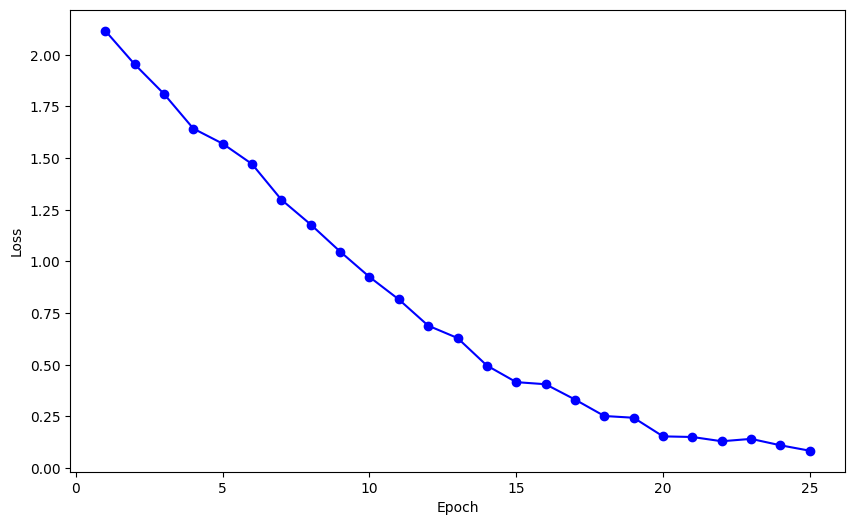

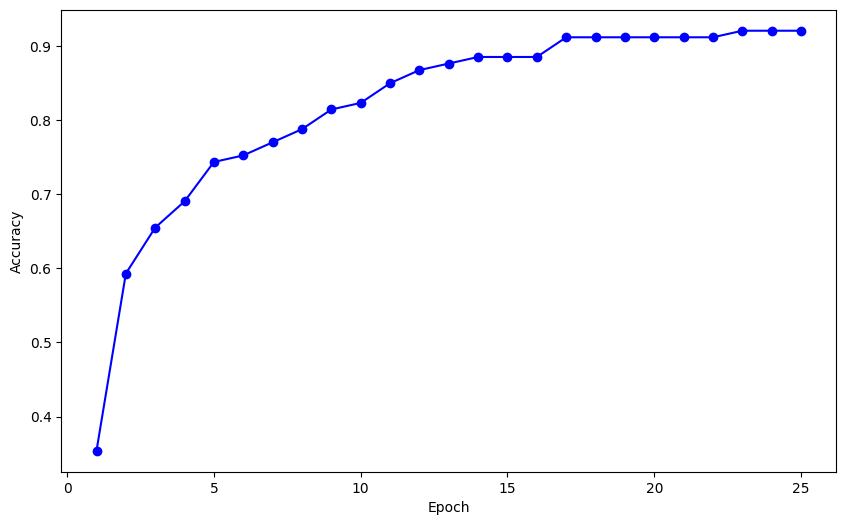

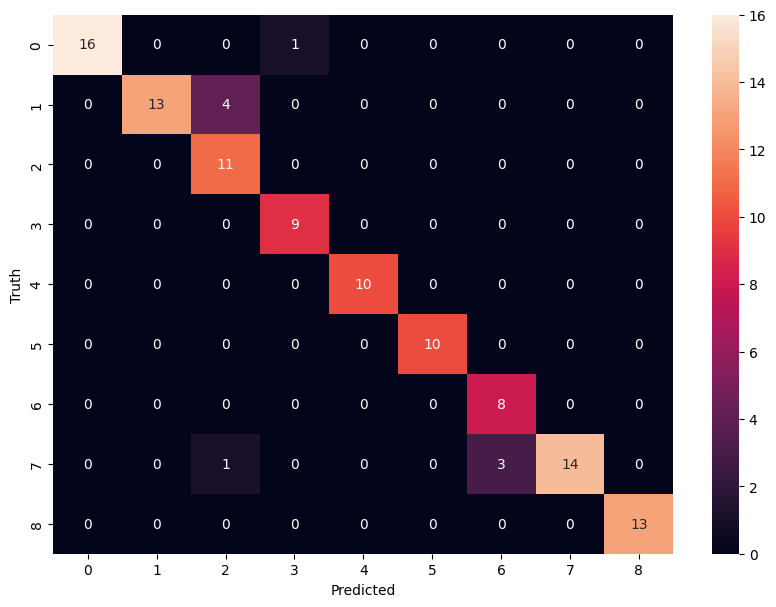

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

data = pd.read_csv(accuracy_filepath)

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(data['epoch'], data['loss'], marker='o', color='b')
# plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(False)
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(data['epoch'], data['accuracy'], marker='o', color='b')
# plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(False)
plt.show()

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# 12. Load the model and test live

In [8]:
import cv2
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import time
import torch.nn as nn


model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
model.load_state_dict(torch.load("./models/lstm_image_rnn_25_epoch_9_classes.pth"))
model.eval()

SCALER = StandardScaler()
ENCODER = LabelEncoder()

frame_buffer = []
output_buffer = []

# Function to process the frame and make predictions
def process_frame(image):
    global frame_buffer, output_buffer

    flattened_image = image.flatten()

    frame_buffer.append(flattened_image)

    # Maintain only the last 5 frames in the buffer
    if len(frame_buffer) >= capture_frames:
        frame_buffer = frame_buffer[-capture_frames:]

    if len(frame_buffer) == capture_frames:
        values = np.array(frame_buffer)
        input_tensor = torch.tensor(values, dtype=torch.float32)
        # Reshape the input tensor to (1, capture_frames, input_size)
        input_tensor = input_tensor.view(1, capture_frames, -1).to(
            device
        )

        with torch.no_grad():
            output = model(input_tensor)
            output_buffer.append(output)

            _, predicted_class = torch.max(output, 1)

            return training_classes[predicted_class]


displayed_prediction = None
previousTime = 0
previousTime_1 = 0

# Open the video capture
capture = cv2.VideoCapture(1)

# Loop through the frames
while capture.isOpened():
    # Read the frame from the video capture
    ret, image = capture.read()

    # resizing the frame for better view
    image = cv2.resize(image, (800, 600))

    filtered_image = apply_image_filters(image, False)

    resized_image = cv2.resize(filtered_image, (256, 256))

    # Process the frame and make predictions
    prediction = process_frame(resized_image)

    visual_image = cv2.cvtColor(filtered_image, cv2.COLOR_GRAY2RGB)

    if prediction is not None:
        # Draw the predictions on the frame (if required)
        cv2.putText(
            visual_image,
            f"Prediction: {prediction}",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 0),
            2,
        )

    # Calculating the FPS
    fps = 1 / (time.time() - previousTime)
    previousTime = time.time()

    # Displaying FPS on the image
    cv2.putText(
        visual_image,
        str(int(fps)) + " FPS",
        (10, 70),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2,
    )

    # Display the image
    cv2.imshow("Frame", visual_image)

    # Check for key press to exit the loop
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break


# Release the video capture and close the window
capture.release()
cv2.destroyAllWindows()